In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import argrelmax as armax
from scipy.signal import argrelmin as armin
from scipy.optimize import curve_fit

import numpy as np

In [2]:
##Define Constants needed to calculate G
I = 1.4208E-4
R = 0.046103
M = 1.03838
m = 14.573
m /= 1000
d = 0.066653
b = 1.337E-3
K = 46.1 ##From Manual, voltage.angle conversion factor(like our sclaing factor but much larger)
uncertainty = 2.47E-12 ##From mathematica notebook

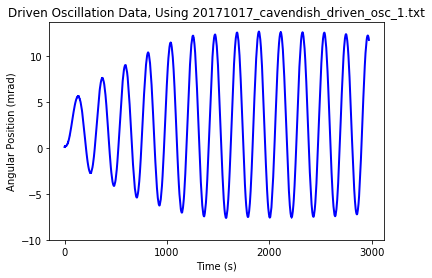

In [3]:
##Load in the data from the text file
data_dir = "../data/"
filename = '20171017_cavendish_driven_osc_1.txt'
data = np.loadtxt(data_dir+filename, delimiter = '\t')

plt.plot(data[:,0], data[:,1], 'b-', linewidth = 2)
plt.title("Driven Oscillation Data, Using "+filename)
plt.ylabel("Angular Position (mrad)")
plt.xlabel("Time (s)")
plt.xticks([0, 1000, 2000, 3000])
plt.yticks([-10, -5, 0, 5, 10]);

In [4]:
##When do we reach a steady state oscillation?
cutoff_time = 1450

##Find the index corrsesponding to, roughly, when the "constant" amplitude oscialltion begins
cutoff = 0

##Reduce the data based on the index
for i in range(data.shape[0]):
    if data[i,0] >= cutoff_time:
        cutoff = i
        break

##Define the data array to now only look at the steady state
data = data[i:,:]

##Use scipy built in method to isolate relative maxima and minima
max_inds = armax(data[:,1], order=25)
min_inds = armin(data[:,1], order = 25)

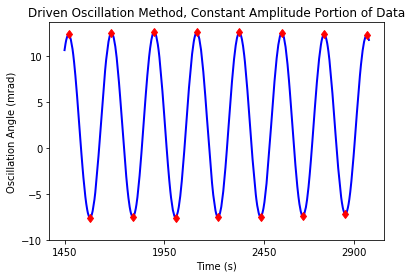

In [5]:
##Data and plotting for isolation of maxima and minima
max_times = data[max_inds,0]
max_angles = data[max_inds, 1]

min_times = data[min_inds, 0]
min_angles = data[min_inds, 1]


plt.plot(data[:,0], data[:,1], 'b-', linewidth = 2)
plt.plot(max_times, max_angles, 'rd')
plt.plot(min_times, min_angles, 'rd')
plt.title("Driven Oscillation Method, Constant Amplitude Portion of Data")
plt.ylabel("Oscillation Angle (mrad)")
plt.xlabel("Time (s)")
plt.xticks([cutoff_time, cutoff_time+500, cutoff_time+1000, cutoff_time+cutoff_time])
plt.yticks([-10, -5, 0, 5, 10]);

I can now isolate the minimums and maximums, which gives me the angles for the turning points. First, I will fit this to a sin function to get the frequency of oscillation.

In [6]:
period = []
for t in range(1, len(max_times[0])):
    period.append(abs(max_times[0][t] - max_times[0][t-1]))
avg_period = np.average(period)
avg_frequency = 2*np.pi/avg_period

w = (avg_frequency**2 + b**2)**(1/2)
w

0.029520902804464701

In [8]:
dw = ((1.432E-6)**2+(1E-2)**2)**(1/2)
dw

0.010000000102531199

In [9]:
##Isolate the turning points
theta = np.concatenate((max_angles[0], min_angles[0]))
print("Number of turning points in calculation: {}.".format(len(theta)))

##Break the code if we have an even number of turning points
if len(theta)%2==0:
    asdfasdfasdfasdfasdf

Number of turning points in calculation: 15.


In [10]:
##Calculate thetaD
x_denom = 0
for i in range(len(theta)-1):
    if i%2 == 0:
        x_denom += theta[i]
    elif i%2!=0:
        x_denom -= theta[i]
    else: 
        raise ValueError
x = 1 - (theta[0] - theta[-1])/x_denom

xp_denom = 0
for j in range(1, len(theta)-2):
    if j%2!=0:
        xp_denom += theta[j]
    elif j%2==0:
        xp_denom -= theta[j]
    else:
        raise ValueError
xp = 1 - (theta[1] - theta[-2])/xp_denom

X = (x+xp)/2

In [20]:
##Calculate thetaD
even_inds = np.arange(0,len(theta),2)
odd_inds = np.arange(1, len(theta), 2)

thetaD = abs(((1-X) * (np.sum(theta[even_inds]) - np.sum(theta[odd_inds])) - theta[0] + X*theta[-1])/((len(theta)-1)*(1+X)))
thetaD = thetaD*1E-3
thetaD

1.0771777024884183e-05

In [18]:
##Find the associated uncertainty
dtheta = 5E-5
dx = 1E-3
d_thetad = dtheta*((len(theta)-1)*(1-x)**2+2*x)**(1/2)/((len(theta)-1)*(1+x))
d_thetadx = dx*(2*x_denom+(theta[-1]-theta[0]))/((len(theta)-1)*(1+x**2))
dthetad = (d_thetad**2 + d_thetadx**2)**(1/2)
dthetad *= 1E-3
dthetad

1.3164833673915739e-08

In [13]:
G = K*((w**2*thetaD)*I*R**2)/(2*M*m*d)
G

6.4786407004710694e-11

In [14]:
print("Results --> Calculated Value of G: {} +/- {} m^3/(kg s^2). Percent Error from Expected Value: {}%.".format(G, uncertainty, (6.67408E-11 - G)/(6.67408E-11) * 100))

Results --> Calculated Value of G: 6.47864070047107e-11 +/- 2.47e-12 m^3/(kg s^2). Percent Error from Expected Value: 2.9283331864306534%.


In [15]:
##Write the calculation to a text file in the Results directory. Matches the resulting calculation to datafile.
with open('../Results/'+filename, 'w') as file:
    file.write("Results --> Calculated Value of G: {} +/- {} m^3/(kg s^2). Percent Error from Expected Value: {}%.".format(G, uncertainty, (6.67408E-11 - G)/(6.67408E-11) * 100))